In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cartoon-sketches/cartoon-sketches/image_000250.png
/kaggle/input/cartoon-sketches/cartoon-sketches/image_001259.png
/kaggle/input/cartoon-sketches/cartoon-sketches/image_001447.png
/kaggle/input/cartoon-sketches/cartoon-sketches/image_001448.png
/kaggle/input/cartoon-sketches/cartoon-sketches/image_001100.png
/kaggle/input/cartoon-sketches/cartoon-sketches/image_000600.png
/kaggle/input/cartoon-sketches/cartoon-sketches/image_001198.png
/kaggle/input/cartoon-sketches/cartoon-sketches/image_001169.png
/kaggle/input/cartoon-sketches/cartoon-sketches/image_001915.png
/kaggle/input/cartoon-sketches/cartoon-sketches/image_000570.png
/kaggle/input/cartoon-sketches/cartoon-sketches/image_001151.png
/kaggle/input/cartoon-sketches/cartoon-sketches/image_001658.png
/kaggle/input/cartoon-sketches/cartoon-sketches/image_001828.png
/kaggle/input/cartoon-sketches/cartoon-sketches/image_000027.png
/kaggle/input/cartoon-sketches/cartoon-sketches/image_000104.png
/kaggle/input/cartoon-ske

In [34]:
import torch 
from torch import nn
from PIL import Image
import torchvision
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [35]:
class CNNBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=2):
        super().__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=4,stride=stride,padding=1,bias=False,padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels,affine=True),
            nn.LeakyReLU(0.2)
            
        )
    def forward(self,X):
        return self.conv(X)
        

In [36]:
class Discriminator(nn.Module):
    def __init__(self,in_channels=3,features=[64,128,256,512]):
        super().__init__()
        self.initial=nn.Sequential(
            nn.Conv2d(in_channels=in_channels*2,out_channels=features[0],kernel_size=4,stride=2,padding=1,padding_mode='reflect'),
            nn.LeakyReLU(0.2)
        )
        layers=[]
        in_channels=features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels=in_channels,out_channels=feature,stride=1 if feature == features[-1] else 2)
            )
            in_channels=feature
        layers.append(
            nn.Conv2d(in_channels=in_channels,out_channels=1,kernel_size=4,stride=1,padding=1,padding_mode='reflect')
        )
        self.model=nn.Sequential(*layers)
        
    def forward(self,x,y):
        x=torch.cat([x,y],dim=1)
        x=self.initial(x)
        return self.model(x)
         

In [37]:
class Block(nn.Module):
    def __init__(self,in_channels,out_channels,down=True,act='relu',use_dropout=False):
        super().__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=4,stride=2,padding=1,bias=False,padding_mode='reflect')
            if down
            else
            nn.ConvTranspose2d(in_channels=in_channels,out_channels=out_channels,kernel_size=4,stride=2,padding=1,bias=False),
            nn.InstanceNorm2d(out_channels,affine=True),
            nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
            
        )
        self.use_dropout=use_dropout
        self.dropout=nn.Dropout(0.5)
        
    def forward(self,x):
        x=self.conv(x)
        return self.dropout(x) if self.use_dropout else x
        

In [38]:
class Generator(nn.Module):
    def __init__(self,in_channels=3,features=64):
        super().__init__()
        #N*C*256*256
        self.initial_down=nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=features,kernel_size=4,stride=2,padding=1,padding_mode='reflect'),
            nn.LeakyReLU(0.2)
        )#N*64*128*128
        self.down1=Block(in_channels=features,out_channels=features*2,down=True,act='leaky',use_dropout=False)
        self.down2=Block(in_channels=features*2,out_channels=features*4,down=True,act='leaky',use_dropout=False)
        self.down3=Block(in_channels=features*4,out_channels=features*8,down=True,act='leaky',use_dropout=False)
        self.down4=Block(in_channels=features*8,out_channels=features*8,down=True,act='leaky',use_dropout=False)
        self.down5=Block(in_channels=features*8,out_channels=features*8,down=True,act='leaky',use_dropout=False)
        self.down6=Block(in_channels=features*8,out_channels=features*8,down=True,act='leaky',use_dropout=False)
        self.bottleneck=nn.Sequential(
            nn.Conv2d(in_channels=features*8,out_channels=features*8,kernel_size=4,stride=2,padding=1,padding_mode='reflect'),
            nn.ReLU()
        )
        self.up1=Block(in_channels=features*8,out_channels=features*8,down=False,act='relu',use_dropout=True)
        self.up2=Block(in_channels=features*8*2,out_channels=features*8,down=False,act='relu',use_dropout=True)
        self.up3=Block(in_channels=features*8*2,out_channels=features*8,down=False,act='relu',use_dropout=True)
        self.up4=Block(in_channels=features*8*2,out_channels=features*8,down=False,act='relu',use_dropout=False)
        self.up5=Block(in_channels=features*8*2,out_channels=features*4,down=False,act='relu',use_dropout=False)
        self.up6=Block(in_channels=features*4*2,out_channels=features*2,down=False,act='relu',use_dropout=False)
        self.up7=Block(in_channels=features*2*2,out_channels=features,down=False,act='relu',use_dropout=False)
        self.final_up=nn.Sequential(
            nn.ConvTranspose2d(in_channels=features*2,out_channels=in_channels,kernel_size=4,stride=2,padding=1),
            nn.Tanh()
        )

    
    def forward(self,x):
        d1=self.initial_down(x)
        d2=self.down1(d1)
        d3=self.down2(d2)
        d4=self.down3(d3)
        d5=self.down4(d4)
        d6=self.down5(d5)
        d7=self.down6(d6)
        bottleneck=self.bottleneck(d7)
        up1=self.up1(bottleneck)
        up2=self.up2(torch.cat([up1,d7],dim=1))
        up3=self.up3(torch.cat([up2,d6],dim=1))
        up4=self.up4(torch.cat([up3,d5],dim=1))
        up5=self.up5(torch.cat([up4,d4],dim=1))
        up6=self.up6(torch.cat([up5,d3],dim=1))
        up7=self.up7(torch.cat([up6,d2],dim=1))
        return self.final_up(torch.cat([up7,d1],dim=1))

        
        

In [39]:
import numpy as np
import os
from torch.utils.data import Dataset

import albumentations as A
from albumentations.pytorch import ToTensorV2


LEARNING_RATE = 2e-4
BATCH_SIZE = 32
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
NUM_EPOCHS = 50




both_transform = A.Compose(
    [A.Resize(width=256, height=256),], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

In [40]:

class CartoonDataSet(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)
        
    def __len__(self):
        return len(self.list_files)
    
    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))

       
        height, width, _ = image.shape

        if width < 2 * height:
            raise ValueError(f"Image width is too small: {width}")

       
        half_width = width // 2
        target_image = image[:, :half_width, :]
        input_image = image[:, half_width:, :]

        
        if input_image.shape != target_image.shape:
            raise ValueError(f"Shapes of input_image and target_image do not match: {input_image.shape} vs {target_image.shape}")

        augmentations = both_transform(image=input_image, image0=target_image)
        input_image, target_image = augmentations['image'], augmentations['image0']
        input_image = transform_only_input(image=input_image)['image']
        target_image = transform_only_mask(image=target_image)['image']
        
        return input_image, target_image

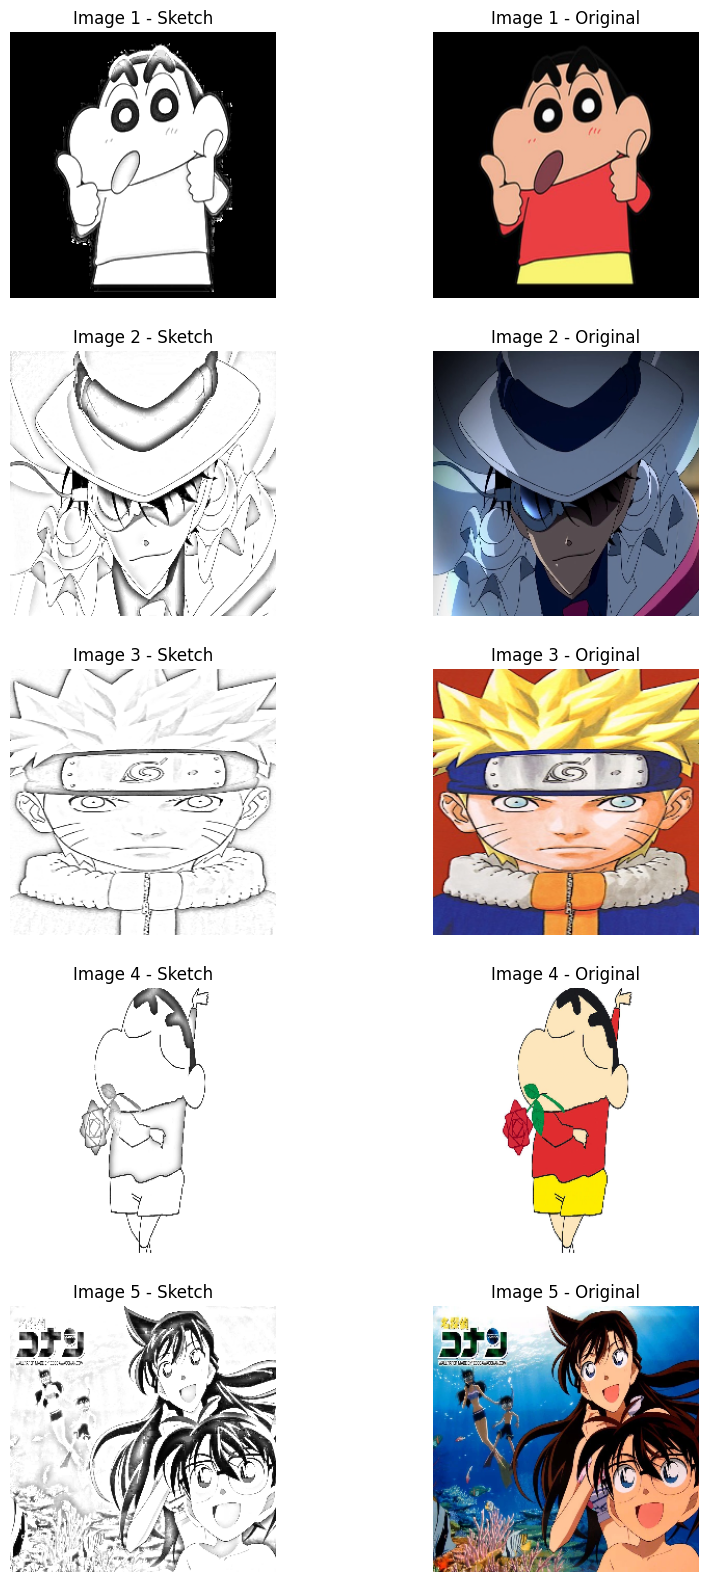

In [44]:
dataset=CartoonDataSet(root_dir='/kaggle/input/cartoon-sketches/cartoon-sketches')
 

plt.figure(figsize=(10, 20))
nrows = 5
ncols = 2
for i in range(nrows):
    idx = np.random.randint(0, len(dataset))
    img1, img2 = dataset[idx]

    if img1.min() < 0 or img1.max() > 1:
        img1 = (img1 - img1.min()) / (img1.max() - img1.min())
    if img2.min() < 0 or img2.max() > 1:
        img2 = (img2 - img2.min()) / (img2.max() - img2.min())

    plt.subplot(nrows, ncols, 2 * i + 1)
    plt.imshow(img1.permute(1, 2, 0))
    plt.title(f'Image {i+1} - Sketch')
    plt.axis('off')

    plt.subplot(nrows, ncols, 2 * i + 2)
    plt.imshow(img2.permute(1, 2, 0))
    plt.title(f'Image {i+1} - Original')
    plt.axis('off')




In [45]:
dataloader=DataLoader(dataset=dataset,batch_size=BATCH_SIZE,shuffle=True)
print(f"There are almost {len(dataloader)} batches of batch_size:{BATCH_SIZE}")

There are almost 73 batches of batch_size:32


In [46]:
g_scaler=torch.cuda.amp.GradScaler()
d_scaler=torch.cuda.amp.GradScaler()


In [47]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device:{device}")

Using device:cuda


In [48]:
disc=Discriminator(in_channels=3).to(device)
gen=Generator(in_channels=3).to(device)
opt_disc=torch.optim.Adam(params=disc.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
opt_gen=torch.optim.Adam(params=gen.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
BCE=nn.BCEWithLogitsLoss()
L1Loss=nn.L1Loss()


In [49]:
for epoch in tqdm(range(NUM_EPOCHS)):
    for idx,(X,y) in enumerate(dataloader):
        X,y=X.to(device),y.to(device)
        with torch.cuda.amp.autocast():
            y_fake=gen(X)
            D_real=disc(X,y)
            D_fake=disc(X,y_fake.detach())
            D_real_loss=BCE(D_real,torch.ones_like(D_real))
            D_fake_loss=BCE(D_fake,torch.zeros_like(D_fake))
            D_loss=(D_real_loss+D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        with torch.cuda.amp.autocast():
            D_fake=disc(X,y_fake)
            G_fake_loss=BCE(D_fake,torch.ones_like(D_fake))
            L1=L1Loss(y_fake,y) * L1_LAMBDA
            G_loss=G_fake_loss+ L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()








  0%|          | 0/50 [00:00<?, ?it/s]

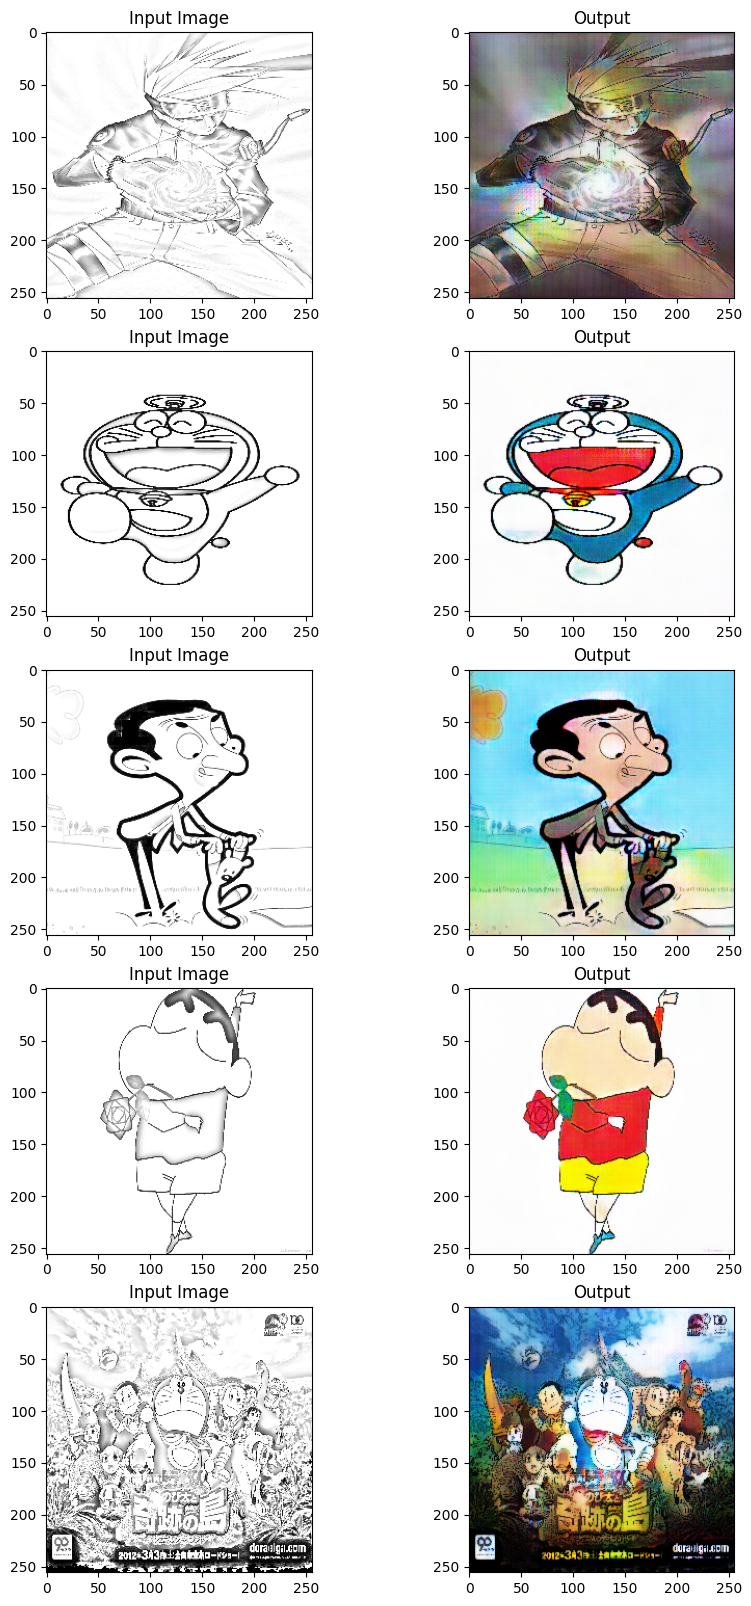

In [50]:
import random
device = 'cuda'
fig, axes = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    X,y = dataset[random.randint(1,50)]
    gen.eval()
    with torch.inference_mode():
        out =(gen(X.to(device).unsqueeze(0)) * 0.5) + 0.5
    gen.train()

    axes[i][0].imshow((X.cpu().detach().squeeze(0).permute(1,2,0)+1)/2)
    axes[i][0].set_title('Input Image')


    axes[i][1].imshow(out.cpu().squeeze(0).permute(1,2,0))
    axes[i][1].set_title('Output')

In [52]:
val_dataset=CartoonDataSet(root_dir='/kaggle/input/cartton-test/cartoon-test-sketches')


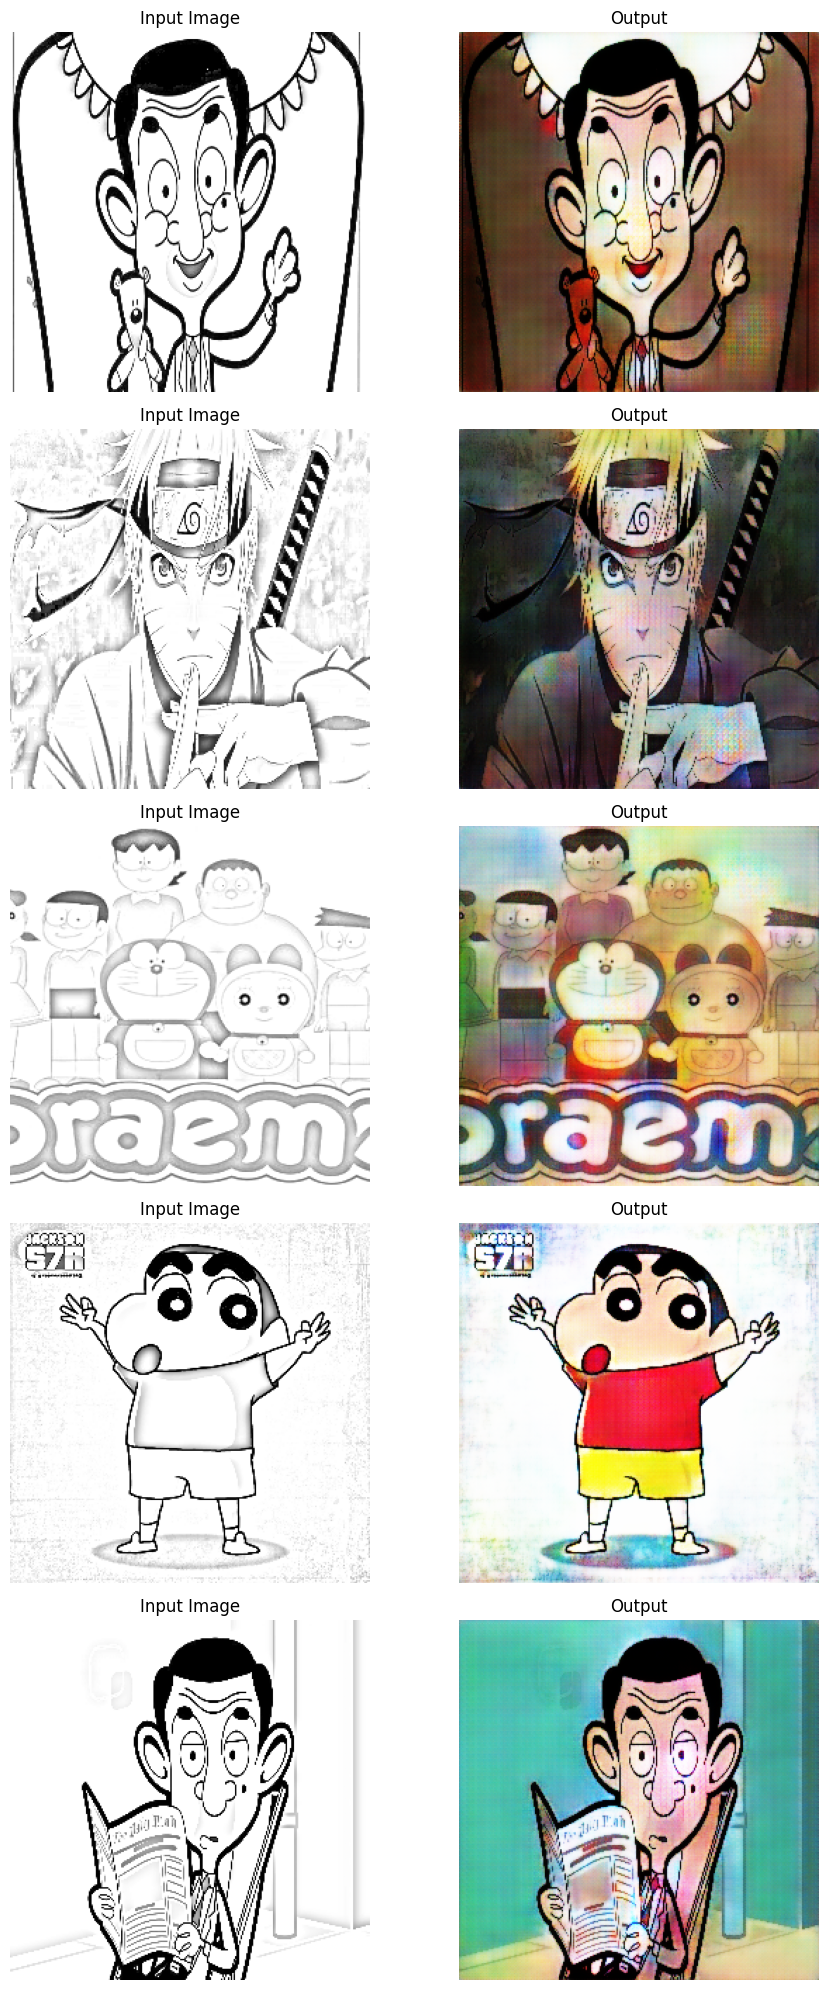

In [60]:
import random
import torch
import matplotlib.pyplot as plt

device = 'cuda'
fig, axes = plt.subplots(5, 2, figsize=(10, 20))

for i in range(5):
    X, y = val_dataset[random.randint(1, 20)]
    gen.eval()
    with torch.inference_mode():
        out = (gen(X.to(device).unsqueeze(0)) * 0.5) + 0.5
    gen.train()

    axes[i][0].imshow((X.cpu().detach().squeeze(0).permute(1, 2, 0) + 1) / 2)
    axes[i][0].set_title('Input Image')
    axes[i][0].axis('off')

    axes[i][1].imshow(out.cpu().squeeze(0).permute(1, 2, 0))
    axes[i][1].set_title('Output')
    axes[i][1].axis('off')

plt.tight_layout()
plt.savefig('/kaggle/working/figure.png')
plt.show()


In [57]:
print("The state dict keys: \n\n", gen.state_dict().keys())

The state dict keys: 

 odict_keys(['initial_down.0.weight', 'initial_down.0.bias', 'down1.conv.0.weight', 'down1.conv.1.weight', 'down1.conv.1.bias', 'down2.conv.0.weight', 'down2.conv.1.weight', 'down2.conv.1.bias', 'down3.conv.0.weight', 'down3.conv.1.weight', 'down3.conv.1.bias', 'down4.conv.0.weight', 'down4.conv.1.weight', 'down4.conv.1.bias', 'down5.conv.0.weight', 'down5.conv.1.weight', 'down5.conv.1.bias', 'down6.conv.0.weight', 'down6.conv.1.weight', 'down6.conv.1.bias', 'bottleneck.0.weight', 'bottleneck.0.bias', 'up1.conv.0.weight', 'up1.conv.1.weight', 'up1.conv.1.bias', 'up2.conv.0.weight', 'up2.conv.1.weight', 'up2.conv.1.bias', 'up3.conv.0.weight', 'up3.conv.1.weight', 'up3.conv.1.bias', 'up4.conv.0.weight', 'up4.conv.1.weight', 'up4.conv.1.bias', 'up5.conv.0.weight', 'up5.conv.1.weight', 'up5.conv.1.bias', 'up6.conv.0.weight', 'up6.conv.1.weight', 'up6.conv.1.bias', 'up7.conv.0.weight', 'up7.conv.1.weight', 'up7.conv.1.bias', 'final_up.0.weight', 'final_up.0.bias'])


In [59]:
checkpoint = {'model': Generator(),
              'state_dict': gen.state_dict(),
              'optimizer' : opt_gen.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')